In [337]:
from collections import defaultdict
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

### 0. Environment setup

1. Downsample image 8x (200 x 200 --> 25 x 25)
2. 500 steps per episode
3. New agent position every episode

In [338]:
minigrid_config = {'size': [25, 25],
                   'steps': 500,
                   'reset_same': False,
                   'reset_episodes': 1}
mode = 'multiroom'
env_id=None
set_seed(333)

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


In [340]:
# minigrid_config = {'size': [19, 19],
#                    'steps': 500,
#                    'reset_same': False,
#                    'reset_episodes': 1}
# mode = 'image'
# env_id='MiniGrid-FourRooms-v0'
# set_seed(333)

# env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

In [341]:
device = torch.device('cuda', 0)

### 1. Collect data

1. 10,000 total steps

In [342]:
steps = int(1e4)

In [343]:
eps_count = 0

In [344]:
obs = env.reset()
data = np.expand_dims(obs, 0)
episodes = np.array([eps_count])

In [345]:
for i in range(steps):
    s, _, d, _ = env.step(env.action_space.sample())
    data = np.append(data, np.expand_dims(s, 0), axis=0)
    episodes = np.append(episodes, [0], axis=0)
    if d:
        data = np.append(data, np.expand_dims(env.reset(), 0), axis=0)
        eps_count += 1
        episodes = np.append(episodes, [eps_count], axis=0)

In [346]:
print(data.shape)
print(episodes.shape)

(10021, 25, 25, 3)
(10021,)


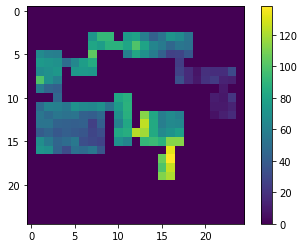

In [347]:
plt.imshow(env.visited.T)
plt.colorbar()

### 2. Separate into positive and negative pairs

1. 1,000 anchors randomly sampled from collected data
2. Positive samples are defined as +/- 3 time steps from anchor, i.e. [t - 3, t + 3]
3. Negative samples are randomly sampled from [t - 100, t - 50] and [t + 50, t + 100]
4. Each anchor has an equal number of positive and negative sampled paired with it
5. Made sure that pairs all come from same episode

In [348]:
num_anchors = 1000 

In [349]:
n_samples = data.shape[0]

In [350]:
X = []
y = []

In [351]:
anchors = np.random.choice(range(n_samples), size=num_anchors)

In [352]:
neg_threshold = 50
pos_threshold = 3

In [353]:
for anchor in anchors:
    anchor_episode = episodes[anchor]
    
    examples = 0
    for idx in range(anchor - pos_threshold, anchor + pos_threshold + 1):
        if idx >= 0  and idx < n_samples and idx != anchor and episodes[idx] == anchor_episode:
            X.append([anchor, idx])
            y.append(0)
            examples += 1
    
    neg_examples = np.random.choice(list(range(anchor - 2 * neg_threshold, anchor - neg_threshold)) +
                                    list(range(anchor + neg_threshold, anchor + 2 * neg_threshold)), size=4 * neg_threshold)

    i = 0
    while True:
        if examples == 0:
            break
        
        idx = neg_examples[i]
        i += 1
        
        if idx >= 0 and idx < n_samples and episodes[idx] == anchor_episode:
            X.append([anchor, idx])
            y.append(1)
            examples -= 1

In [354]:
X = np.array(X)

In [355]:
data = torch.Tensor(data).to(device)

In [356]:
y = torch.Tensor(y).to(device)

In [357]:
y.sum()

tensor(5987., device='cuda:0')

### 3. Define model

1. 2 conv layers, 1 linear layer
2. Feature size = 64

In [358]:
class TCN(torch.nn.Module):

    def __init__(
            self,
            image_shape,
            output_size,
            feature_size=64
            ):
        super().__init__()
        h, w, c = image_shape

        self.output_size = output_size
        self.feature_size = feature_size

        conv_embedding_size = 16 * (((h - 3) // 2) - 1) ** 2

        self.encoder = nn.Sequential(
            nn.Conv2d(c, 16, (3, 3), stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(conv_embedding_size, feature_size)
        )

    def forward(self, obs):
        x = obs.type(torch.float)
        x = x.permute(0, 3, 1, 2)
        return self.encoder(x)

### 4. Training

1. Defined distance function to be 1 - cosine similarity of normed features
2. Trained with joint hinge loss on positive and negative pairs
3. Margin for negative samples = 0.3, i.e. we only care about negative samples whose cosine similarity < 0.7

In [359]:
feature_size = 64

In [360]:
del model
model = TCN(env.observation_space.shape, env.action_space.n, feature_size)
model.to(device)
N = X.shape[0]
learning_rate = 1e-4
epochs = 500
batch_size = 128
# optim_kwargs = dict(eps=0.01 / N)
clip_grad_norm = 10
log_interval = 50
m = 0.3

In [361]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
pos_losses = []
neg_losses = []
grad_norms = []

In [362]:
def l2_distance(a, b):
    return torch.norm(a - b, dim=1)

In [363]:
def cos_distance(a, b):
    a = a / torch.norm(a, dim=1, keepdim=True)
    b = b / torch.norm(b, dim=1, keepdim=True)
    return 1 - torch.sum(a * b, dim=1)

In [364]:
for epoch in range(epochs):

    permutation = torch.randint(0, N, (N, ))
    
    epoch_losses = []
    epoch_pos_losses = []
    epoch_neg_losses = []
    epoch_grad_norms = []
    
    for i in range(0, N, batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i: i + batch_size]
        
        X_batch = X[indices]
        y_batch = y[indices]
        
        anchor_embeddings = model(data[X_batch[:, 0]])
        sample_embeddings = model(data[X_batch[:, 1]])
        
        pos_loss = torch.mean((1 - y_batch) * cos_distance(anchor_embeddings, sample_embeddings))
        neg_loss = torch.mean(y_batch * torch.clamp(m  - cos_distance(anchor_embeddings, sample_embeddings), min=0))
        
        loss = pos_loss + neg_loss
        
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
            
        epoch_losses.append(loss.item())
        epoch_pos_losses.append(pos_loss.item())
        epoch_neg_losses.append(neg_loss.item())
        epoch_grad_norms.append(grad_norm)
    
    losses.append(np.mean(epoch_losses))
    pos_losses.append(np.mean(epoch_pos_losses))
    neg_losses.append(np.mean(epoch_neg_losses))
    grad_norms.append(np.mean(epoch_grad_norms))
    
    if epoch % log_interval == 0:
        print('Epoch {}: loss = {:.3f}, pos_loss = {:.3f}, neg_loss = {:.3f}'.format(epoch, losses[-1], pos_losses[-1], neg_losses[-1]))

Epoch 0: loss = 0.145, pos_loss = 0.010, neg_loss = 0.136
Epoch 50: loss = 0.053, pos_loss = 0.021, neg_loss = 0.032
Epoch 100: loss = 0.052, pos_loss = 0.021, neg_loss = 0.031
Epoch 150: loss = 0.051, pos_loss = 0.020, neg_loss = 0.031
Epoch 200: loss = 0.049, pos_loss = 0.020, neg_loss = 0.030
Epoch 250: loss = 0.050, pos_loss = 0.020, neg_loss = 0.030
Epoch 300: loss = 0.048, pos_loss = 0.019, neg_loss = 0.029
Epoch 350: loss = 0.051, pos_loss = 0.020, neg_loss = 0.031
Epoch 400: loss = 0.050, pos_loss = 0.020, neg_loss = 0.030
Epoch 450: loss = 0.049, pos_loss = 0.020, neg_loss = 0.029


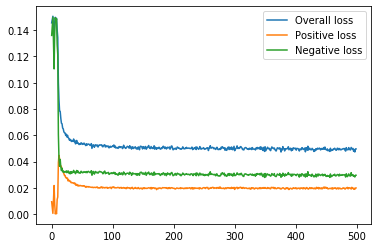

In [365]:
plt.plot(losses, label='Overall loss')
plt.plot(pos_losses, label='Positive loss')
plt.plot(neg_losses, label='Negative loss')
plt.legend()

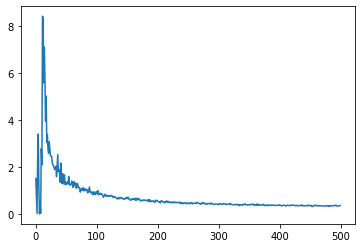

In [366]:
plt.plot(grad_norms)

### 5. Visualize results

1. Computed features for all positive states
2. Computed cosine similarity between all states and a selected subgoal state, e.g. (4, 13)

In [367]:
obs = env.reset()
h, w = env.grid.height, env.grid.width
features = torch.zeros((h, w, 4, 64), dtype=torch.float)
features += np.nan

In [368]:
# positions = set()
# for r in range(19):
#     for c in range(19):
#         if r not in [0, 9, 18] and c not in [0, 9, 18]:
#             for action in range(4):
#                 env.env.env.unwrapped.agent_pos = np.array([r, c])
#                 _, _, done, _ = env.step(action)

#                 pos = tuple(env.agent_pos)
#                 if pos not in positions:
#                     positions.add(pos)

#                 if done:
#                     env.reset()

# for pos in positions:
#     for direction in range(4):
#         env.env.env.unwrapped.agent_pos = np.array(pos)
#         env.env.env.unwrapped.agent_dir = direction
#         obs, _, _, _ = env.step(4)
#         model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)
#         features[pos[0], pos[1], direction] = model(model_inputs)

In [375]:
h, w = env.grid.height, env.grid.width
features = torch.zeros((h, w, 4, 64), dtype=torch.float)
features += np.nan

for room in env.rooms:
    start_x, start_y = room.top
    size_x, size_y = room.size
    for direction in range(4):
        for r in range(start_x + 1, start_x + size_x - 1):
            for c in range(start_y + 1, start_y + size_y - 1):
                env.env.env.unwrapped.agent_pos = np.array([r, c])
                env.env.env.unwrapped.agent_dir = direction
                obs, _, _, _ = env.env.env.step(5)

                model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)
                
                features[r, c, direction] = model(model_inputs)

        if room.exitDoorPos is not None:
            exit_door = np.array(room.exitDoorPos)
            env.env.env.unwrapped.agent_pos = exit_door
            env.env.env.unwrapped.agent_dir = direction
            obs, _, _, _ = env.env.env.step(5)
            
            model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)
            
            features[exit_door[0], exit_door[1], direction] = model(model_inputs)


In [376]:
features.shape

torch.Size([25, 25, 4, 64])

In [393]:
subgoal = (16, 18)

In [394]:
np_features = features.detach().numpy()

features_matrix = np_features.mean(axis=2)

features_matrix = features_matrix / np.linalg.norm(features_matrix, ord=2, axis=2, keepdims=True)

subgoal_features = features_matrix[subgoal]

side_size = features_matrix.shape[0]
heatmap = np.zeros((side_size, side_size))
for r in range(side_size):
    for c in range(side_size):
        heatmap[r, c] = np.dot(features_matrix[r, c], subgoal_features)
#         heatmap[r, c] = np.linalg.norm(features_matrix[r, c] - subgoal_features)

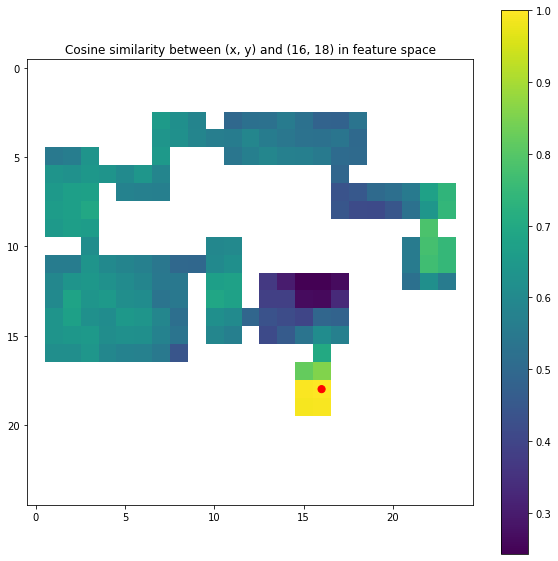

In [395]:
plt.figure(figsize=(10, 10))
plt.imshow(heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.title('Cosine similarity between (x, y) and {} in feature space'.format(subgoal))
plt.colorbar()

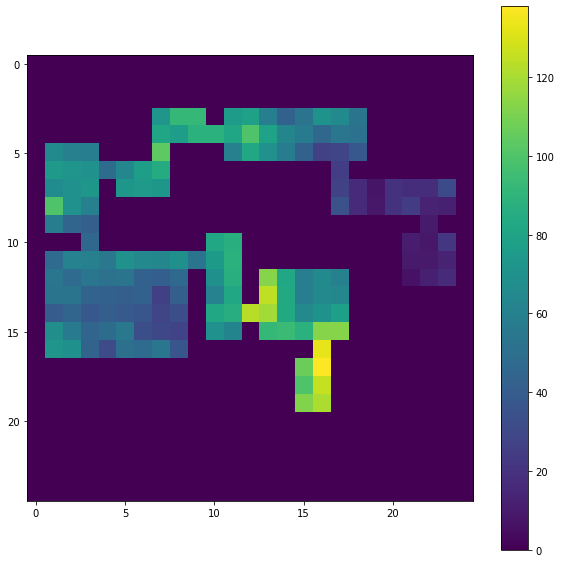

In [396]:
plt.figure(figsize=(10, 10))
plt.imshow(env.visited.T)
plt.colorbar()